# 1 Preparing

In [9]:
import os
from gensim import models
import pandas as pd

In [111]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [148]:
dataset_files = {}
dictionary_files = {}

# Target dataset (which is used for the true classification)
key_dataset = "coffee.xlsx"
dict_name = 'coffee_dict.xlsx'

# *** Datasets ***
dataset_path = '/home/jupyter/work/resources/content/datasets/'
dict_path = '/home/jupyter/work/resources/content/dictionaries/'

# Dataset structure - used for the source datasets fields
req_str = 'text'

# 2 Load data

In [7]:
# *** Datasets loading***
for entry in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, entry)):
        dataset_files[entry] = dataset_path + entry
        
# *** Loadingf of dictionaries with brands and support words ***
for entry in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, entry)):
        dictionary_files[entry] = dataset_path + entry

In [16]:
# Define the positive dataset
positive_dataset = pd.read_excel(dataset_files[key_dataset], header=None, names=[req_str], engine='openpyxl')
positive_dataset['label'] = 1

# Define the negative dataset

cont_dataset = pd.DataFrame()

for key, value in dataset_files.items():
    if key != key_dataset:
        tmp = pd.read_excel(value, header=None, names=[req_str], engine='openpyxl')
        tmp['label'] = 0
        
        # Checking that your target dataset does not contain the fields from other sets
        positive_dataset.drop(positive_dataset[positive_dataset[req_str].isin(tmp[req_str])].index, inplace=True)
        
        # Add a new part to the negative dataset 
        cont_dataset = pd.concat([cont_dataset, tmp], sort=False)

cont_dataset = cont_dataset.sample(frac = 1).reset_index(drop=True)

# Let us define the train data set which we are going to use during our model fitting, 
# and the validation dataset for the following checking of the model.

# Train Dataset
df_train = pd.concat([
    positive_dataset[:(round(positive_dataset.shape[0]*0.75))],
    cont_dataset[:(round(cont_dataset.shape[0]*0.75))]
]).sample(frac = 1).reset_index(drop=True)

# Validation dataset
df_val = pd.concat([
    positive_dataset[(round(positive_dataset.shape[0]*0.75)):],
    cont_dataset[(round(cont_dataset.shape[0]*0.75)):]
]).sample(frac = 1).reset_index(drop=True)

# 3 Preprocess data analysing

In [98]:
print("------")
print("Basic statistics")
print("")
print("Train shape: ", df_train.shape)
print("Validation shape: ", df_val.shape)
true_label = (df_train.label.value_counts() / df_train.shape[0])[1]
false_label = (df_train.label.value_counts() / df_train.shape[0])[0]
print(f"Class distribution:\n True = {round(true_label*100, 2)}%,\n False = {round(false_label*100, 2)}%")
print("")
print("------")
print("Label basic statistics")
print("")
print(df_train['label'].value_counts())
print("")
print("------")
print("Text basic statistics")
print("")
print('Total unique reqests counts:', len(df_train[req_str].unique()))
print("Mean amount of words in sentences (train dataset): ", df_train[req_str].str.split().map(len).mean())
print("Mean chars amount in sentences (train dataset): ", df_train[req_str].str.len().mean())
print("Max amount of words in sentences (train dataset): ", df_train[req_str].str.split().map(len).max())
print("Max chars amount in sentences (train dataset): ", df_train[req_str].str.len().max())
print("Mean amount of words in sentences (validation dataset): ", df_val[req_str].str.split().map(len).mean())
print("Mean chars amount in sentences (validation dataset): ", df_val[req_str].str.len().mean())
print("Max amount of words in sentences (validation dataset): ", df_val[req_str].str.split().map(len).max())
print("Max chars amount in sentences (validation dataset): ", df_val[req_str].str.len().max())
print("")
print("------")

------
Basic statistics

Train shape:  (432878, 2)
Validation shape:  (144293, 2)
Class distribution:
 True = 1.29%,
 False = 98.71%

------
Label basic statistics

0    427287
1      5591
Name: label, dtype: int64

------
Text basic statistics

Total unique reqests counts: 432731
Mean amount of words in sentences (train dataset):  3.571847033113256
Mean chars amount in sentences (train dataset):  24.173413756300853
Max amount of words in sentences (train dataset):  16
Max chars amount in sentences (train dataset):  100
Mean amount of words in sentences (validation dataset):  3.569979139667205
Mean chars amount in sentences (validation dataset):  24.15932858835841
Max amount of words in sentences (validation dataset):  15
Max chars amount in sentences (validation dataset):  95

------


<AxesSubplot:title={'center':'Amount of words in sentences'}>

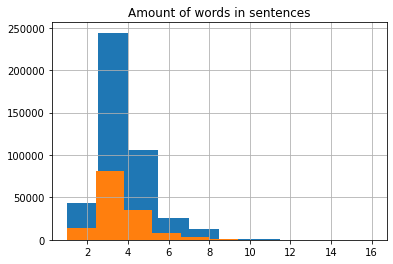

In [96]:
df_train[req_str].str.split().map(len).hist().set_title('Amount of words in sentences')
df_val[req_str].str.split().map(len).hist()

<AxesSubplot:title={'center':'Chars amount in sentences'}>

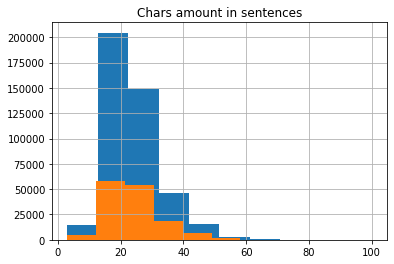

In [99]:
df_train[req_str].str.len().hist().set_title('Chars amount in sentences')
df_val[req_str].str.len().hist()

In [101]:
df_train.isnull().values.any(), df_val.isnull().values.any(),

(False, False)

# 4 Preprocess data

In [140]:
russian_stopwords = set(stopwords.words("russian"))

def preprocess_text(text):
    #tokens = mystem.lemmatize(text.lower())
    tokens = nltk.tokenize.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    #text = " ".join(tokens)
    
    #return text
    return tokens

df_train['tokens'] = df_train[req_str].apply(preprocess_text)
df_val['tokens'] = df_train[req_str].apply(preprocess_text)
#df_train['cleaned_text'] = df_train[req_str].apply(preprocess_text)
#df_val['cleaned_text'] = df_val[req_str].apply(preprocess_text)

In [141]:
df_train

,text,label,cleaned_text,tokens
0,наборы фигурок миньоны,0,наборы фигурок миньоны,"[наборы, фигурок, миньоны]"
1,bandai megazord,0,bandai megazord,"[bandai, megazord]"
2,чайный домик ниндзяго,0,чайный домик ниндзяго,"[чайный, домик, ниндзяго]"
3,игрушки брудер мусоровоз цена,0,игрушки брудер мусоровоз цена,"[игрушки, брудер, мусоровоз, цена]"
4,кукла shibajuku girls купить интернет магазин,0,кукла shibajuku girls купить интернет магазин,"[кукла, shibajuku, girls, купить, интернет, ма..."
...,...,...,...,...
432873,электронные игры для девочек холодное сердце,0,электронные игры девочек холодное сердце,"[электронные, игры, девочек, холодное, сердце]"
432874,паровозик для детей игрушка купить,0,паровозик детей игрушка купить,"[паровозик, детей, игрушка, купить]"
432875,памперсы кораблик цена,0,памперсы кораблик цена,"[памперсы, кораблик, цена]"
432876,игрушка мазда демио,0,игрушка мазда демио,"[игрушка, мазда, демио]"


In [142]:
df_val

,text,label,cleaned_text,tokens
0,купить игрушечная мастерская,0,купить игрушечная мастерская,"[наборы, фигурок, миньоны]"
1,игрушка chericole,0,игрушка chericole,"[bandai, megazord]"
2,растения для акватеррариума,0,растения акватеррариума,"[чайный, домик, ниндзяго]"
3,kami l espresso oro,1,kami l espresso oro,"[игрушки, брудер, мусоровоз, цена]"
4,minecraft steve 1,0,minecraft steve 1,"[кукла, shibajuku, girls, купить, интернет, ма..."
...,...,...,...,...
144288,корм уценка уцененный срок кошек,0,корм уценка уцененный срок кошек,"[детский, набор, строительных, инструментов, м..."
144289,фиолетовая собака мультик,0,фиолетовая собака мультик,"[купить, динозавра, плео, москве]"
144290,интерактивный щенок гоша,0,интерактивный щенок гоша,"[закупка, памперсов, оптом, производителя]"
144291,набор техники военный,0,набор техники военный,"[кукла, пупс, danielle]"


In [147]:
def cnt_uniq(col):
    count = set()
    for line in col:
        count |= set(line)
    return len(count)

print("------")
print("Unique words in df_train.tokens: ", cnt_uniq(df_train.tokens))
print("Unique words in df_val.tokens: ", cnt_uniq(df_val.tokens))
print("------")

------
Unique words in df_train.tokens:  63541
Unique words in df_val.tokens:  36983
------


# 5 Pretrained embeddings as features for classifier

In [154]:
# https://rusvectores.org/ru/models/
# for the ferst approach let us take geowac_tokens_none_fasttextskipgram_300_5_2020
# http://vectors.nlpl.eu/repository/20/214.zip
%time
!wget -c 'http://vectors.nlpl.eu/repository/20/214.zip' --directory-prefix='content/models'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs
--2021-09-18 18:08:05--  http://vectors.nlpl.eu/repository/20/214.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [153]:
!unzip 'content/models/214.zip' -d 'content/models/214'

Archive:  content/models/214.zip
  inflating: content/models/214/meta.json  
  inflating: content/models/214/model.model  
  inflating: content/models/214/model.model.vectors_ngrams.npy  
  inflating: content/models/214/model.model.vectors.npy  
  inflating: content/models/214/model.model.vectors_vocab.npy  
  inflating: content/models/214/README  


In [ ]:
!cp 'content/models/model.model' 'content/models/model.bin'

In [156]:
# from gensim.models.wrappers import FastText

# model = FastText.load_fasttext_format('content/models/214/model.model')

In [ ]:
# import fasttext.util
# fasttext.util.download_model('ru', if_exists='ignore')  # English
# ft = fasttext.load_model('cc.en.300.bin')

In [129]:
cars = {'text': ['наборы а был фигурок без миньоны','bandai megazord','будто чайный домик ниндзяго','игрушки брудер мусоровоз цена'],
        }

df = pd.DataFrame(cars)

In [124]:
df

,text
0,наборы a был фигурок без миньоны
1,bandai megazord
2,будто чайный домик ниндзяго
3,игрушки брудер мусоровоз цена


In [128]:
russian_stopwords

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [130]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df

,text,cleaned_text
0,наборы а был фигурок без миньоны,"[наборы, фигурок, миньоны]"
1,bandai megazord,"[bandai, megazord]"
2,будто чайный домик ниндзяго,"[чайный, домик, ниндзяго]"
3,игрушки брудер мусоровоз цена,"[игрушки, брудер, мусоровоз, цена]"
